# 标签数据构建

In [8]:
import pandas as pd
import os
import chardet

# 检测文件编码
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
        return result['encoding']

# 定义读取文件的函数，支持不同编码
def read_csv_file(file_path, encoding='utf-8', sep=','):
    try:
        df = pd.read_csv(file_path, encoding=encoding, sep=sep)
    except UnicodeDecodeError:
        detected_encoding = detect_encoding(file_path)
        print(f"Detected encoding: {detected_encoding}")
        df = pd.read_csv(file_path, encoding=detected_encoding, sep=sep)
    return df

# 读取 Excel 或 CSV 文件
def read_csv_or_excel(file_path, encoding='utf-8', sep=','):
    if file_path.endswith('.xlsx') or file_path.endswith('.xls'):
        return pd.read_excel(file_path)
    else:
        return read_csv_file(file_path, encoding=encoding, sep=sep)

# 筛选 Cluster 为分类列并生成哑变量
def process_tcmt_data(tcmt_df):
    # 生成哑变量，不加前缀
    tcmt_dummies = pd.get_dummies(tcmt_df[['TCMT_ID', 'Cluster']], columns=['Cluster'], prefix='', prefix_sep='')
    return tcmt_dummies

# 合并 CPM_ID 与 TCMT_ID 的哑变量
def merge_cpm_tcmt(cpm_tcmt_df, tcmt_dummies):
    merged_df = pd.merge(cpm_tcmt_df[['CPM_ID', 'TCMT_ID']], tcmt_dummies, on='TCMT_ID', how='inner')
    return merged_df

# 对 CPM_ID 汇总哑变量
def summarize_by_cpm_id(merged_df):
    cpm_dummies_unique = merged_df.groupby('CPM_ID').max().reset_index()
    cpm_dummies_unique = cpm_dummies_unique.drop(columns=['TCMT_ID'])
    return cpm_dummies_unique

# 保存处理后的数据到文件
def save_to_csv(df, output_file_path):
    df.to_csv(output_file_path, index=False)
    print(f"处理后的唯一数据文件已保存到: {output_file_path}")

# 主函数调用
def main(tcmt_file_path, d3_cpm_tcmt_file_path, output_file_path):
    # 读取 TCMT 文件
    tcmt_df = read_csv_or_excel(tcmt_file_path)

    # 处理 TCMT 数据，生成哑变量
    tcmt_dummies = process_tcmt_data(tcmt_df)

    # 读取 D3_CPM_TCMT 文件
    cpm_tcmt_df = read_csv_file(d3_cpm_tcmt_file_path, sep='\t')

    # 合并 CPM_ID 和 TCMT_ID 哑变量
    merged_df = merge_cpm_tcmt(cpm_tcmt_df, tcmt_dummies)

    # 汇总哑变量
    cpm_dummies_unique = summarize_by_cpm_id(merged_df)

    # 显示处理后的数据
    print(cpm_dummies_unique.head())

    # 保存结果到 CSV 文件
    save_to_csv(cpm_dummies_unique, output_file_path)

# 仅当运行此脚本时才执行主函数
if __name__ == '__main__':
    # 文件路径设置
    work_dir = r'D:\博士文件\博士毕业课题材料\维吾尔医药配伍机制量化分析\data'
    
    # 具体的文件路径
    tcmt_file_path = os.path.join(work_dir, 'umap_filtered_with_kmeans_clusters.xlsx')
    d3_cpm_tcmt_file_path = os.path.join(work_dir, 'UHF_TCMT.tsv')
    output_file_path = os.path.join(work_dir, 'UHF_Cluster_Dummies_Unique.csv')

    # 调用主函数，传入文件路径
    main(tcmt_file_path, d3_cpm_tcmt_file_path, output_file_path)


    CPM_ID  Generate dryness and cold  Generate dryness and heat  \
0  UHF0001                       True                       True   
1  UHF0002                      False                       True   
2  UHF0003                      False                       True   
3  UHF0004                       True                       True   
4  UHF0005                       True                       True   

   Generate moisture and cold  Generate moisture and heat  
0                        True                        True  
1                       False                        True  
2                       False                       False  
3                       False                        True  
4                        True                        True  
处理后的唯一数据文件已保存到: D:\博士文件\博士毕业课题材料\维吾尔医药配伍机制量化分析\data\UHF_Cluster_Dummies_Unique.csv


# 图数据构建
## 尝试引入剂量作为其中一个参数

In [12]:
import os
import pandas as pd
import torch
import networkx as nx
import logging
from torch_geometric.utils import from_networkx
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# 配置日志记录
logging.basicConfig(filename='graph_processing.log', level=logging.INFO)

# 设置工作目录和输入/输出路径
work_dir = r'D:\博士文件\博士毕业课题材料\维吾尔医药配伍机制量化分析\data'
input_data_dir = os.path.join(work_dir)  # 设置数据输入路径
output_dir = os.path.join(work_dir,)  # 设置数据输出路径

# 定义具体的文件路径
file_path = os.path.join(input_data_dir, 'UHF_UHP.tsv')
output_file = os.path.join(output_dir, 'all_graphs_to_be_predicted.pt')
chp_properties_path = os.path.join(input_data_dir, 'UHP_Medicinal_properties_encode.tsv')
chp_encoder_path = os.path.join(input_data_dir, 'UHP_Encoder.tsv')
cluster_dummies_path = os.path.join(input_data_dir, 'UHF_Cluster_Dummies_Unique.csv')
# 加载数据
data = pd.read_csv(file_path, sep='\t')
chp_properties_data = pd.read_csv(chp_properties_path, sep='\t')
chp_encoder_data = pd.read_csv(chp_encoder_path, sep='\t')
cluster_dummies_data = pd.read_csv(cluster_dummies_path)

# 提取标签：根据 CPM_ID 获取标签
def get_labels_for_cpm_id(cpm_id, cluster_dummies_data):
    # 根据 CPM_ID 从 cluster_dummies_data 获取标签
    label_row = cluster_dummies_data[cluster_dummies_data['CPM_ID'] == cpm_id]
    if label_row.empty:
        return None
    # 将标签列转换为数值形式：TRUE -> 1, FALSE -> 0
    labels = label_row[['Generate dryness and cold', 'Generate dryness and heat', 'Generate moisture and cold', 'Generate moisture and heat']].values.flatten().astype(int)
    return labels

# 主函数：处理每个图并转换为 PyG 格式
def process_graph_to_pyg(cpm_id, cpm_chp_data, chp_properties_data, chp_encoder_data, cluster_dummies_data):
    try:
        # 数据预处理
        chp_encoder_data.iloc[:, 1:] = chp_encoder_data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

        # 根据 CPM_ID 过滤数据
        cpm_data = cpm_chp_data[cpm_chp_data['CPM_ID'] == cpm_id]

        # 初始化图
        G = nx.MultiGraph()

        # 添加实际节点，并包含 Dosage_ratio 属性
        chp_ids = cpm_data['CHP_ID'].unique()
        chp_encoder = chp_encoder_data[chp_encoder_data['CHP_ID'].isin(chp_ids)]
        
        for _, row in chp_encoder.iterrows():
            chp_id = row['CHP_ID']
            chp_attr = row[1:].tolist()

            # 获取 Dosage_ratio，并将无效值（如 NaN）转换为 0
            dosage_ratio = cpm_data[cpm_data['CHP_ID'] == chp_id]['Dosage_ratio']
            dosage_ratio = pd.to_numeric(dosage_ratio, errors='coerce').fillna(0).iloc[0]
            chp_attr.append(dosage_ratio)  # 将 Dosage_ratio 作为最后一个特征

            # 将节点添加到图中
            G.add_node(chp_id, feature=chp_attr, type='Actual', name=chp_id)

        # 虚拟节点属性：基于实际节点特征
        virtual_node_features = chp_attr.copy()
        virtual_nodes = ['Dry therapeutic', 'Moist therapeutic', 'Cold therapeutic', 'Hot therapeutic']  # 修改虚拟节点为干、湿、寒、热
        for vn in virtual_nodes:
            G.add_node(vn, feature=virtual_node_features, type='Virtual', name=vn)

        # 连接实际节点和虚拟节点
        chp_properties = chp_properties_data[chp_properties_data['CHP_ID'].isin(chp_ids)].copy()
        chp_properties['Level'] = chp_properties['Level'].astype(float)  # 使用“等级”代替原来的 x_rank, y_rank

        # 连接实际节点与虚拟节点的边
        for chp_id in chp_ids:
            # 检查是否存在于 chp_properties_data 中
            chp_rows = chp_properties[chp_properties['CHP_ID'] == chp_id]
            if not chp_rows.empty:
                # 存在的情况下，按原逻辑连接
                for _, row in chp_rows.iterrows():
                    attribute = [row['Level']]  # 只使用“等级”
                    G.add_edge(chp_id, row['Medicinal_properties'], attr=attribute)  # 连接实际节点与虚拟节点
            else:
                # 不存在时，默认连接 'Cold therapeutic' 和 'Hot therapeutic'，Level 为 0
                default_level = [0]
                G.add_edge(chp_id, 'Cold therapeutic', attr=default_level)
                G.add_edge(chp_id, 'Hot therapeutic', attr=default_level)

        # 更新虚拟节点属性
        update_virtual_node_features(G, virtual_nodes, virtual_node_features)

        # 设置虚拟节点之间的初始边属性
        initial_edge_attrs = calculate_initial_edge_attributes(G, virtual_nodes)

        # 连接虚拟节点（干和热不相连，寒和湿不相连）
        for i, vn1 in enumerate(virtual_nodes):
            for j, vn2 in enumerate(virtual_nodes):
                if i < j:
                    # 干和热不相连，寒和湿不相连
                    if (vn1 == 'Dry therapeutic' and vn2 == 'Moist therapeutic') or (vn1 == 'Moist therapeutic' and vn2 == 'Dry therapeutic'):
                        continue
                    if (vn1 == 'Cold therapeutic' and vn2 == 'Hot therapeutic') or (vn1 == 'Hot therapeutic' and vn2 == 'Cold therapeutic'):
                        continue
                    G.add_edge(vn1, vn2, attr=initial_edge_attrs)

        # 将无向图转换为有向图
        G = G.to_directed()

        # 确保每条边的两个方向都有相同的特征
        for u, v, k, data in G.edges(keys=True, data=True):
            if 'attr' in data:
                G.edges[v, u, k]['attr'] = data['attr']

        # 转换为 PyG 格式的图
        pyg_graph = convert_to_pyg_graph(G)

        # 获取标签并添加到 PyG 图中
        labels = get_labels_for_cpm_id(cpm_id, cluster_dummies_data)
        if labels is not None:
            pyg_graph.y = torch.tensor(labels, dtype=torch.float32)
        else:
            pyg_graph.y = torch.zeros(4, dtype=torch.float32)  # 如果没有标签，默认标签为全0

        # 添加节点名称和 CPM_ID 到 PyG 图中以便参考
        pyg_graph.node_names = [G.nodes[node]['name'] for node in G.nodes]
        pyg_graph.cpm_id = cpm_id

        return pyg_graph
    except Exception as e:
        logging.error(f"处理 CPM_ID {cpm_id} 时出错: {e}")
        print(f"处理 CPM_ID {cpm_id} 时出错: {e}")  # 调试输出
        return None

# 更新虚拟节点的特征（基于与实际节点的连接）
def update_virtual_node_features(G, virtual_nodes, node_attr_names):
    for vn in virtual_nodes:
        connected_nodes = [node for node in G.neighbors(vn) if G.nodes[node]['type'] == 'Actual']
        if connected_nodes:
            initial_features = G.nodes[vn]['feature']
            weighted_features, total_weight = calculate_weighted_features(G, connected_nodes, vn, node_attr_names)
            if total_weight != 0:
                updated_features = [wf / total_weight for wf in weighted_features]
                G.nodes[vn]['feature'] = [(uf + if_) / 2 for uf, if_ in zip(updated_features, initial_features)]
            else:
                G.nodes[vn]['feature'] = initial_features

# 计算虚拟节点的加权特征
def calculate_weighted_features(G, connected_nodes, vn, node_attr_names):
    weighted_features = [0] * len(node_attr_names)
    total_weight = 0
    for node in connected_nodes:
        node_features = G.nodes[node]['feature']
        edge_data = G.get_edge_data(node, vn)
        for edge_key in edge_data:
            edge_attr = edge_data[edge_key]['attr']
            for ea in edge_attr:
                weighted_features = [wf + f * ea for wf, f in zip(weighted_features, node_features)]
                total_weight += ea
    return weighted_features, total_weight

# 计算虚拟节点之间初始边属性的平均值
def calculate_initial_edge_attributes(G, virtual_nodes):
    initial_edge_attrs = []
    for vn in virtual_nodes:
        for node in G.neighbors(vn):
            if G.nodes[node]['type'] == 'Actual':
                edge_data = G.get_edge_data(node, vn)
                for edge_key in edge_data:
                    edge_attr = edge_data[edge_key]['attr']
                    initial_edge_attrs.append(edge_attr)
    avg_initial_edge_attr = [sum(x) / len(initial_edge_attrs) for x in zip(*initial_edge_attrs)]
    return avg_initial_edge_attr

# 将 networkx 图转换为 PyTorch Geometric 格式
def convert_to_pyg_graph(G):
    pyg_graph = from_networkx(G)
    pyg_graph.x = torch.tensor([G.nodes[node]['feature'] for node in G.nodes], dtype=torch.float)
    pyg_graph.edge_attr = torch.tensor([G.edges[edge]['attr'] for edge in G.edges], dtype=torch.float)
    pyg_graph.node_types = [G.nodes[node]['type'] for node in G.nodes]
    return pyg_graph

# 并行处理图，并保存结果
pyg_graphs = []
unique_cpm_ids = data['CPM_ID'].unique()

with ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(
            process_graph_to_pyg,
            cpm_id,
            data[data['CPM_ID'] == cpm_id],
            chp_properties_data,
            chp_encoder_data,
            cluster_dummies_data
        ) for cpm_id in unique_cpm_ids
    ]
    
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing graphs"):
        result = future.result()
        if result is not None:
            pyg_graphs.append(result)

# 保存处理后的 PyG 图
torch.save(pyg_graphs, output_file)
print(f"成功保存了 {len(pyg_graphs)} 个图到 '{output_file}'")


Processing graphs: 100%|█████████████████████████████████████████████████████████| 480/480 [00:00<00:00, 240562.30it/s]

成功保存了 480 个图到 'D:\博士文件\博士毕业课题材料\维吾尔医药配伍机制量化分析\data\all_graphs_to_be_predicted.pt'


# 查看数据样式

图的数量 (Number of graphs): 480
标签列的数量 (Number of label columns): 4

第 2 张图的详细信息:
节点特征 (Node Features):
tensor([[ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          1.7825e-01, -2.3405e-02,  1.1106e+00,  3.4704e-01,  2.3869e-01,
         -3.5306e-01,  1.3131e+00,  1.4496e+00, -3.6060e-01,  1.0115e-01,
          1.7532e+00, -8.9529e-01, -1.3145e+00,  1.4308e+00,  4.7431e-01,
          1.5825e+00, -8.4996e-01, -1.2968e+00,  1.9876e-01, -1.9702e-01,
         -1.7037e+00, -2.9997e-01,  5.8124e-01,  1.2011e+00,  1.2495e+00,
         -1.6643e-01, -1.6703e+00,  3.8924e+00,  1.2213e+00, -4.7612e-01,
         -1.4219e+00,  1.9013e+00,  2.0183e+00, -3.0868e+00, -5.0780e-01,
          4.0823e+00, -4.2700e-02,  1.3496e-01, -1.1943e+00, -4.5660e-01,
         -1.5090e+00,  5.0787e-01,  1.2309e+00, -2.6667e+00, -1.2957e+00,
         -4.9632e-02, -8.7895e-01,  1.1776e+00,  2.3319e+00,  2.0514e+00,
          5.7355e-01,  1.2819e+00,  2.0456e+00, -5.9216e-01, -3.3917e+00,
         -1

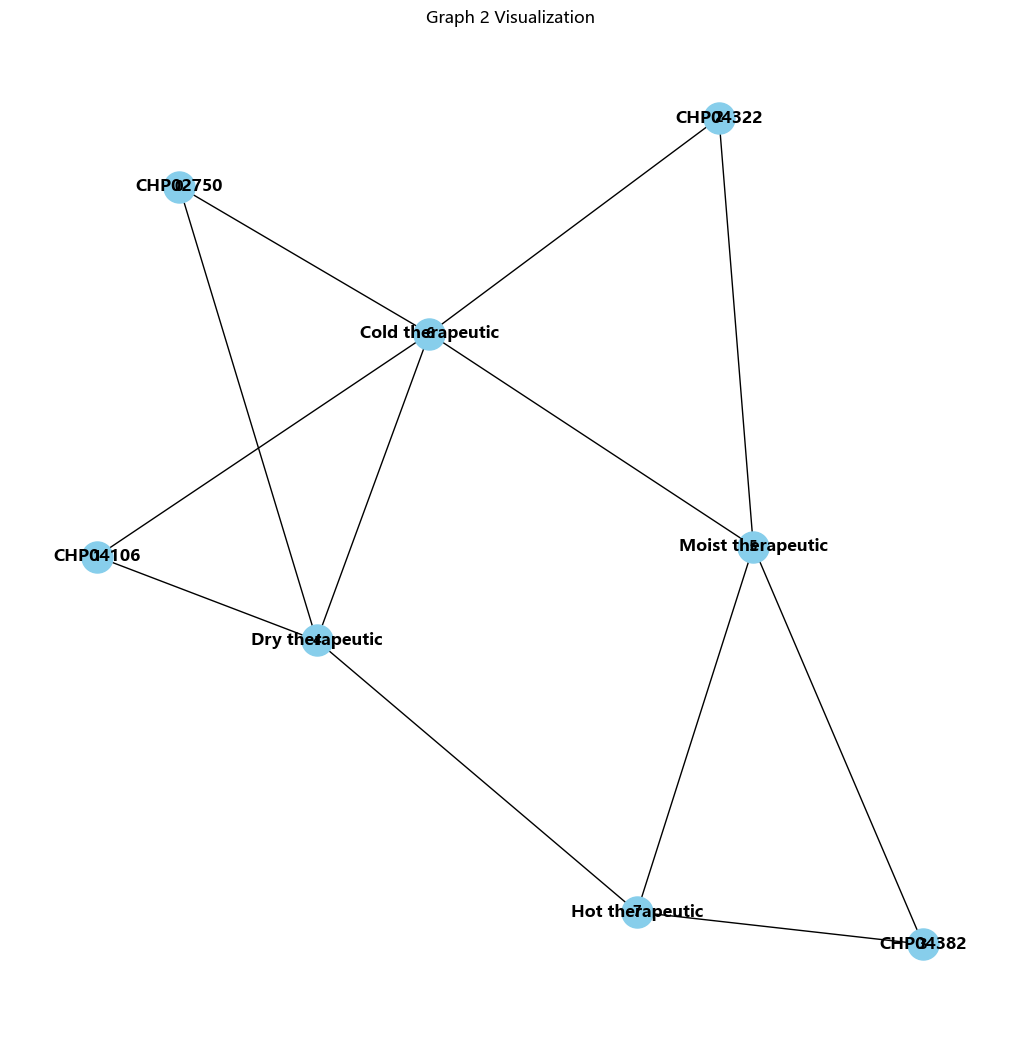

In [15]:
import os
import torch
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import font_manager

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # Windows系统
# 对于MacOS或者其他系统，可能需要调整为其他字体

work_dir = r'D:\博士文件\博士毕业课题材料\维吾尔医药配伍机制量化分析\data'
# 加载 PyG 图
output_file = os.path.join(work_dir, 'all_graphs_to_be_predicted.pt')
loaded_pyg_graphs = torch.load(output_file)

# 查看图的数量
num_graphs = len(loaded_pyg_graphs)
print(f"图的数量 (Number of graphs): {num_graphs}")

# 查看每个图的标签列数
if len(loaded_pyg_graphs) > 0:
    first_graph = loaded_pyg_graphs[0]
    num_label_columns = first_graph.y.size(0) if first_graph.y is not None else 0
    print(f"标签列的数量 (Number of label columns): {num_label_columns}")

# 查看第一个图的详细信息
graph_index = 1  # 可根据需要修改
first_graph = loaded_pyg_graphs[graph_index]
print(f"\n第 {graph_index + 1} 张图的详细信息:")

# 节点特征
print(f"节点特征 (Node Features):\n{first_graph.x}")

# 边索引
print(f"边索引 (Edge Index):\n{first_graph.edge_index}")

# 边属性
if hasattr(first_graph, 'edge_attr'):
    print(f"边属性 (Edge Attributes):\n{first_graph.edge_attr}")
else:
    print("没有边属性 (No Edge Attributes)")

# 标签
if hasattr(first_graph, 'y'):
    print(f"标签 (Labels):\n{first_graph.y}")
else:
    print("没有标签 (No Labels)")

# CPM_ID
if hasattr(first_graph, 'cpm_id'):
    print(f"CPM_ID: {first_graph.cpm_id}")
else:
    print("没有 CPM_ID")

# 节点名称
if hasattr(first_graph, 'node_names'):
    print(f"节点名称 (Node Names):\n{first_graph.node_names}")
    node_names = first_graph.node_names
else:
    print("没有节点名称 (No Node Names)")
    node_names = None

# 节点类型
if hasattr(first_graph, 'node_types'):
    print(f"节点类型 (Node Types):\n{first_graph.node_types}")
else:
    print("没有节点类型 (No Node Types)")

# 构建 NetworkX 图
G = nx.Graph()

# 将边加入到 NetworkX 图中
edge_index = first_graph.edge_index.numpy()
for i in range(edge_index.shape[1]):
    G.add_edge(edge_index[0][i], edge_index[1][i])

# 如果有节点名称，则将节点名称添加到图中
if node_names is not None:
    labels = {i: node_names[i] for i in range(len(node_names))}
else:
    labels = None

# 可视化图
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)  # 布局方式，保证每次生成相同布局
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', font_color='black')

# 显示中文标签，如果节点名称存在
if labels is not None:
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_family='Microsoft YaHei', font_weight='bold')

plt.title(f"Graph {graph_index + 1} Visualization")
plt.show()
